# Classification of Cytosine Variants using HMMs

Author: <a href=http://users.soe.ucsc.edu/~jmschrei/>Jacob Schreiber</a> jmschreiber91@gmail.com

This notebook is intended to show how to use <a href=http://www.github.com/jmschrei/yahmm>YAHMM</a> and <a href=http://www.github.com/jmschrei/PyPore>PyPore</a> in order to analyze real nanopore data.

First, lets import the regular suspects.

In [1]:
%matplotlib inline
import numpy as np
import time

# PyPore.DataTypes is broken - we use pypore_compat instead
# Just show numpy version
print("numpy version: {}".format(np.__version__))
print("Using pypore_compat for data loading")

numpy version: 1.16.6
Using pypore_compat for data loading


Now lets build the model. The functions used come from <a href=https://github.com/UCSCNanopore/Data/blob/master/Automation/epigenetics.py>this script</a>.

In [2]:
from epigenetics_patched import *

with open( 'untrained_hmm.txt', 'r' ) as infile:
    model = Model.read( infile )

We need to then load up some data. Data is captured at a sampling frequency of 100kHz in 12.5 minute increments. The first few files are usually control files to make sure that the system is working correctly, before adding in all of the substrates. The process of event detection and segmentation on this much data can take a while, so after event detection and segmentation, sometimes a JSON of the analysis is stored for easy lookup. We have a function which will load the JSON if present, otherwise it will analyze the ABF file.

In [3]:
# JSON files are in Data/ subdirectory
filenames = [ 'Data/14418004-s04.abf', 'Data/14418005-s04.abf', 'Data/14418006-s04.abf',
          'Data/14418007-s04.abf', 'Data/14418008-s04.abf', 'Data/14418009-s04.abf', 
          'Data/14418010-s04.abf', 'Data/14418011-s04.abf', 'Data/14418012-s04.abf', 
          'Data/14418013-s04.abf', 'Data/14418014-s04.abf', 'Data/14418015-s04.abf', 
          'Data/14418016-s04.abf' ]

events = get_events( filenames, model )

	Data/14418004-s04.json successfully read
	Data/14418005-s04.json successfully read
	Data/14418006-s04.json successfully read
	Data/14418007-s04.json successfully read
	Data/14418008-s04.json successfully read
	Data/14418009-s04.json successfully read
	Data/14418010-s04.json successfully read
	Data/14418011-s04.json successfully read
	Data/14418012-s04.json successfully read
	Data/14418013-s04.json successfully read
	Data/14418014-s04.json successfully read
	Data/14418015-s04.json successfully read
	Data/14418016-s04.json successfully read


Now we have all the events in all of the files. An event is defined as a region of ionic current below 90 pA, above 0 pA, and longer than 500 ms. Some of these events will contain useful information, and some will not. 

We need to now split the data into a training set, cross training set, and a testing set.

In [4]:
train_fold, test_fold = train_test_split( events, 0.7 )
train_fold, cross_train_fold = train_test_split( train_fold, 0.7 )

We can train on the training set, and test on the cross training set for an initial look at the data. Some events are off pathway, which means that training on them would likely throw the model off, even using Baum-Welch. We need to find a threshold by which to filter events which are off pathway, just to ensure we aren't throwing a significant amount of garbage at the model. Since we are testing to see if the events have a similar structure to the model, we calculate the sum of the scores across the cytosine fork and multiply by the sum of scores across the label fork. This ensures that the event passes through both the cytosine and label forks, without penalizing miscalls (which would be cheating).

In order to do this, we will train the model on events passing the filter on the training fold, and then calculate the accuracy on the cross-train fold. This is a computationally intensive process, so we comment it out here. The best filter thresholds were 0.05 and 0.10, and so 0.10 was chosen manually to be used downstream. 

In [9]:
data = threshold_scan( train_fold, cross_train_fold )

Threshold set at 0.01
Training improvement: 41.753221334
Training improvement: 7.63437510356
Training improvement: 4.62880909922
Training improvement: 3.18442564735
Training improvement: 3.10929736972
Training improvement: 2.64160174973
Training improvement: 1.97228719775
Training improvement: 1.34062625746
Training improvement: 0.74101371002
Training improvement: 0.488818610837
Total Training Improvement:  67.4944760797
Threshold set at 0.02
Training improvement: 42.691767606
Training improvement: 8.8391233596
Training improvement: 3.39742868694
Training improvement: 3.30462753583
Training improvement: 3.34121851419
Training improvement: 1.95117446926
Training improvement: 2.82155915565
Training improvement: 1.26394603776
Training improvement: 1.10441458603
Training improvement: 1.53915269329
Total Training Improvement:  70.2544126445
Threshold set at 0.05
Training improvement: 42.7635342625
Training improvement: 10.5395767513
Training improvement: 4.34734667797
Training improvement: 

If we wanted to look at how well our model performed, we could create a plot showing the expected number of transitions to the non-match states across the model.  We would train the model on the training set, and calculate the expected number of transitions using the cross-training set.

In [11]:
model = train( model, train_fold, threshold=0.1 )

Scoring Events Took 45.0737509727s
92 events after filtering
Training improvement: -0.593513861899
Total Training Improvement:  -0.593513861899
Training on 92 events took 38.8221309185


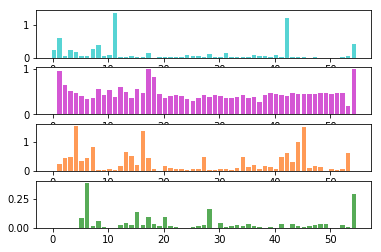

In [13]:
insert_delete_plot( model, cross_train_fold )

We get a version of the plot shown in the paper, with a few positions of high insert count, overall intermediate levels of deletes, and occasional backslips and undersegmented regions. More analysis of this graph is in the paper.

Now, lets calculate an accuracy score using this model. We'll need to reload it so that the prior training doesn't influence it, and then train it on the entire training and cross-training set. 

In [15]:
with open( 'untrained_hmm.txt', 'r' ) as infile:
    model = Model.read( infile )
model = train( model, train_fold+cross_train_fold, threshold=0.1 )

Scoring Events Took 65.8459188938s
135 events after filtering
Training improvement: 42.1474835677
Training improvement: 8.48470921001
Training improvement: 4.02939526294
Training improvement: 3.40149439783
Training improvement: 2.78596063195
Training improvement: 3.60733578623
Training improvement: 1.94351912959
Training improvement: 0.863705548182
Training improvement: 1.39866219011
Training improvement: 0.854243293679
Total Training Improvement:  69.5165090182
Training on 135 events took 361.076756001


Now lets score the testing set, and make some plots of the accuracy.

In [17]:
data = test( model, test_fold )
n = len( data['MCSC'] )

(0, 127)

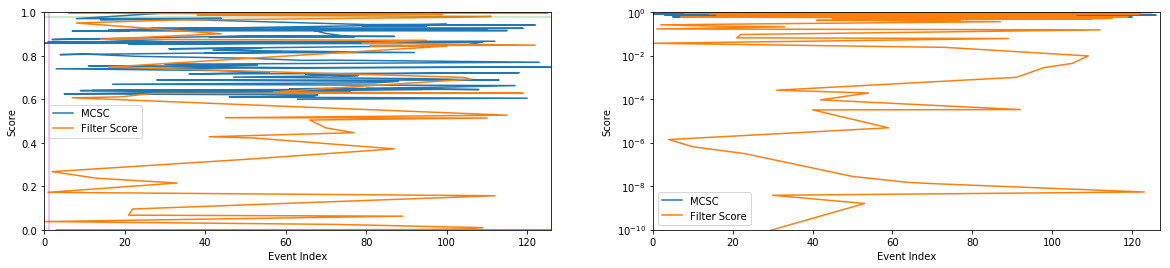

In [19]:
plt.figure( figsize=(20, 4) )
plt.subplot(121)
plt.plot( data['MCSC'][::-1], label='MCSC' )
plt.plot( data['Filter Score'][::-1], label='Filter Score')
plt.xlabel( 'Event Index' )
plt.ylabel( 'Score' )
plt.plot( [n*.26, n*.26], [0, 1.0], c='m', alpha=0.3 )
plt.plot( [0, 126], [0.977, 0.977], alpha=0.3  )
plt.legend()
plt.ylim( 0, 1 )
plt.xlim( 0, 126 )

plt.subplot(122)
plt.plot( data['MCSC'][::-1], label='MCSC' )
plt.plot( data['Filter Score'][::-1], label='Filter Score')
plt.xlabel( 'Event Index' )
plt.ylabel( 'Score' )
plt.legend()
plt.yscale('log')
plt.ylim( 1e-10, 1 )
plt.xlim( 0, 127 )

These plots show the mean cumulative soft call (what accuracy do I get using events this good or better) and the filter score against the ranking of the event, when the events have been ranked in order of their filter score. We can see that the filter score begins to drastically fall around the 20th event. This drop is drastic, as shown by the picture on the log scale.

(1, 1e-10)

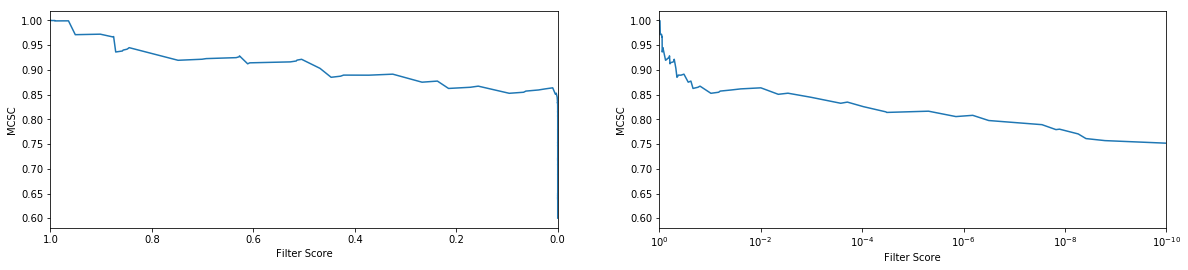

In [20]:
plt.figure( figsize=( 20,4 ) )
plt.subplot(121)
plt.plot( data['Filter Score'], data['MCSC'] )
plt.ylabel( 'MCSC' )
plt.xlabel( 'Filter Score' )
plt.xlim( 1, 0 )

plt.subplot(122)
plt.plot( data['Filter Score'], data['MCSC'] )
plt.xscale( 'log' )
plt.ylabel( 'MCSC' )
plt.xlabel( 'Filter Score' )
plt.xlim( 1, 1e-10 )

We can now look at a plot of the filter score versus the MCSC, in order to investigate what filter score should be used as a threshold in order to get the desired score. 

(0, 127)

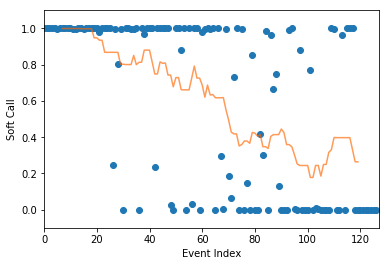

In [21]:
plt.scatter( range( len( data['Soft Call'] ) )[::-1], data['Soft Call'] )
plt.plot( range( -7, 120 ), data['Soft Call'][::-1].rolling(15).mean(), c='#FF6600', alpha=0.66 )
plt.ylabel( 'Soft Call' )
plt.xlabel( 'Event Index' )
plt.ylim( -0.1, 1.1 )
plt.xlim( 0, 127 )

Now we can plot the soft call of each index, and a rolling mean accuracy. This tells us what the accuracy is like in a local area, meaning 'what is the accuracy of events like this one' as opposed to the cumulative effect of 'what is the accuracy of this event or better.' 

Now lets run 5-fold cross-validation 10 times in order to make sure we didn't have a lucky train-test split.

In [ ]:
import random

# Warning: This function takes a very long time to run, as there are n*m training steps which have
# ~10 iterations each, for ~500 iterations of Baum-Welch training, each taking ~20-200 seconds to complete.
# The uncertainty in number of iterations is that the training will go for a maximum of 10 iterations, but
# terminate if the improvement is below 0. 
n = 5 # Number of folds to have in n-fold cross-validation
m = 10 # Number of times to run n-fold cross-validation

accuracies = []
for i in xrange( m ):
    print "\nIteration {}".format( i )
    random.shuffle( events )
    accuracies.append( n_fold_cross_validation( events, n=n ) )
    
accuracies = np.array( accuracies )


Iteration 0
Scoring Events Took 111.370880842s
156 events after filtering
Training improvement: 42.3013629092
Training improvement: 5.68025884792
Training improvement: 3.15413893886
Training improvement: 1.87133804895
Training improvement: 0.925331744722
Training improvement: 1.17216766613
Training improvement: 1.35099430914
Training improvement: 1.38153319631
Training improvement: 0.932186760029
Training improvement: 1.19707275836
Total Training Improvement:  59.9663851797
Training on 156 events took 761.551995993
Scoring Events Took 138.976809025s
153 events after filtering
Training improvement: 57.5735561622
Training improvement: 14.4171230639
Training improvement: 2.21577316767
Training improvement: 1.73231919352
Training improvement: 3.28983980355
Training improvement: 1.74284477531
Training improvement: 0.837603131046
Training improvement: 0.377200482862
Training improvement: 0.199540719786
Training improvement: 0.129141095929
Total Training Improvement:  82.5149415958
Training 

In [ ]:
plt.figure( figsize=(10, 5))
plt.plot( accuracies.T.mean( axis=1 )  )
plt.fill_between( xrange(0, 423), accuracies.T.min( axis=1 ), accuracies.T.max( axis=1 ), color='b', alpha=0.33 )
plt.plot( [105.75, 105.75], [0.5, 1.0], c='r', alpha=0.5 )
plt.plot( [0, 423], [.977, .977], c='g', alpha=0.5 )
plt.ylim( 0.5, 1 )
plt.xlim( 0, 423 )
plt.ylabel( 'MCSC Accuracy' )
plt.xlabel( 'Event Index' )

These values are slightly different than the ones reported in the paper, due to shuffle being run without a deterministic seed used on both instances. However, the results are mostly the same, being slightly higher in this run than in the paper due to random chance, with the mean of this run at 97.7% accuracy using the top 26% of the data instead of the 97.0% calculated in the paper.